In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install wordcloud

In [ ]:
!pip install wordcloud

In [1]:
import os
import sqlite3
import requests
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

In [5]:
conn = sqlite3.connect(os.path.join(os.path.dirname(os.getcwd()), 'instance', 'corpora.db'))

In [6]:
cur = conn.cursor()

In [7]:
def find_item_num(ru_name: str, class_name: str) -> None:
    print(f'Кол-во {ru_name}: {cur.execute(f"SELECT COUNT(*) FROM {class_name}").fetchone()[0]}')

In [8]:
find_item_num('текстов', 'texts')
find_item_num('предложений', 'sentences')
find_item_num('лемм', 'lemmas')
find_item_num('словоформ', 'word_forms')
find_item_num('токенов', 'trigrams')

Кол-во текстов: 1332
Кол-во предложений: 39961
Кол-во лемм: 33233
Кол-во словоформ: 64454
Кол-во токенов: 514523


In [9]:
lemmas = cur.execute("""
    SELECT l.text AS lemma
    FROM trigrams t
    INNER JOIN lemmas l
    ON l.id = t.first_lemma_id""").fetchall()

In [10]:
our_corpora_text = ' '.join([l[0] for l in lemmas])

In [11]:
conn.close()

In [12]:
r = requests.get('https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu')

In [13]:
ref_corpora_text = ''

for token in tqdm(r.text.split('\n')):
    if not token.startswith('#') and token:
        info = token.split('\t')
        if info[3] != 'PUNCT':
            ref_corpora_text += info[2] + ' '

100%|██████████| 499731/499731 [02:47<00:00, 2980.73it/s] 


In [14]:
stop_words = stopwords.words("russian")

In [15]:
tfidf = TfidfVectorizer(
    analyzer="word",
    stop_words=stop_words
)

In [16]:
censored = {
'жопа': 'ж*па',
'говна': 'г*вна',
'хуй': 'х*й',
'блять': 'бл*ть',
'срать': 'ср*ть',
'говно': 'г*вно',
'член': 'чл*н',
'пиздец': 'п**дец'
}

In [17]:
def get_top_tf_idf_words(tfidf_vector, feature_names, top_n):
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    sorted_values = np.sort(tfidf_vector.data)[:-(top_n+1):-1]
    words = feature_names[tfidf_vector.indices[sorted_nzs]]
    return {censored[words[i]] if words[i] in censored else words[i]: sorted_values[i] for i in range(top_n)}

In [18]:
texts_tfidf = tfidf.fit_transform([our_corpora_text, ref_corpora_text])
feature_names = np.array(tfidf.get_feature_names_out())

dvach_words = get_top_tf_idf_words(texts_tfidf[0, :], feature_names, 50)

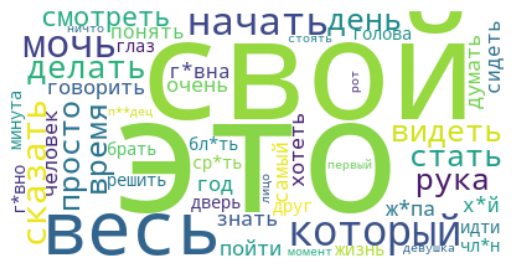

In [19]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate_from_frequencies(dvach_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()